### Requirements

In [25]:
!pip freeze | grep scikit

scikit-image==0.16.2
scikit-learn==0.23.2
scikit-plot==0.3.7


In [26]:
!pip freeze | grep pycaret

pycaret==2.2.3


# Cours 6 - Modélisation

## Imports

In [47]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics._regression import _check_reg_targets
from sklearn.utils.validation import check_consistent_length
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from pycaret.regression import *

In [48]:
def mean_absolute_percentage_error(y_true, y_pred):
    """in percent"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100


def get_evaluation_metrics(y_test, y_pred, y_train=None) -> dict:
    metrics = {
        'mape': mean_absolute_percentage_error(y_test, y_pred),
        'mse': mean_squared_error(y_test, y_pred, squared=False),
        'rmse': mean_squared_error(y_test, y_pred, squared=True),
        'mae': mean_absolute_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred),
    }
    return metrics


def prettify_metrics(metrics: dict) -> str:
    output = [f"Evaluation:\n{'-'*10}"]
    for name, metric in metrics.items():
        output.append((f'- {name.upper()}: {round(metric, 2)}'))
    return '\n'.join(output)

## Opening data

In [2]:
!ls ../data

data_prepared_ponts.csv          movie-features-24nov2020.json
french-box-office-23nov2020.json movie-features-29nov2020.json
french-box-office-29nov2020.json


In [21]:
data = pd.read_csv('../data/data_prepared_ponts.csv')

In [22]:
data.head()

,id,year,sales,release_date,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,...,prod_FR,prod_GB,prod_H,prod_O,prod_OTHER,prod_R,prod_S,prod_T,prod_U,prod_US
0,19073,2019,786485,2019-10-16,1,185000000.0,110.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,18875,2019,1261701,2019-05-01,1,25000000.0,135.0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,18243,2019,1370178,2019-07-03,1,160000000.0,129.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,18258,2019,785636,2019-12-04,1,125000000.0,123.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,18167,2019,1224811,2019-02-06,1,129000000.0,104.0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


## Dataset exploration

In [26]:
data.head()

,id,year,sales,release_date,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,...,prod_FR,prod_GB,prod_H,prod_O,prod_OTHER,prod_R,prod_S,prod_T,prod_U,prod_US
0,19073,2019,786485,2019-10-16,1,185000000.0,110.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,18875,2019,1261701,2019-05-01,1,25000000.0,135.0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,18243,2019,1370178,2019-07-03,1,160000000.0,129.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,18258,2019,785636,2019-12-04,1,125000000.0,123.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,18167,2019,1224811,2019-02-06,1,129000000.0,104.0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [27]:
data.shape

(6676, 43)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6676 entries, 0 to 6675
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     6676 non-null   int64  
 1   year                   6676 non-null   int64  
 2   sales                  6676 non-null   int64  
 3   release_date           6676 non-null   object 
 4   is_part_of_collection  6676 non-null   int64  
 5   budget                 6676 non-null   float64
 6   runtime                6671 non-null   float64
 7   original_lang_en       6676 non-null   int64  
 8   original_lang_es       6676 non-null   int64  
 9   original_lang_fr       6676 non-null   int64  
 10  original_lang_it       6676 non-null   int64  
 11  original_lang_ja       6676 non-null   int64  
 12  original_lang_other    6676 non-null   int64  
 13  available_lang_de      6676 non-null   int64  
 14  available_lang_en      6676 non-null   int64  
 15  avai

In [52]:
data.describe()

,id,year,sales,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,...,prod_FR,prod_GB,prod_H,prod_O,prod_OTHER,prod_R,prod_S,prod_T,prod_U,prod_US
count,6676.000000,6676.000000,6.676000e+03,6676.000000,6.676000e+03,6671.000000,6676.000000,6676.000000,6676.000000,6676.000000,...,6676.000000,6676.000000,6676.000000,6676.000000,6676.000000,6676.000000,6676.000000,6676.000000,6676.000000,6676.000000
mean,10451.755992,2010.402187,1.927583e+05,0.140503,3.294390e+07,101.746815,0.515728,0.023966,0.363691,0.016327,...,0.429599,0.111294,0.001648,0.001648,0.251348,0.025764,0.011534,0.001648,0.011534,0.421061
std,6578.421242,5.779975,3.454426e+05,0.347534,3.434553e+07,23.671101,0.499790,0.152956,0.481097,0.126740,...,0.495056,0.314520,0.040561,0.040561,0.433821,0.158442,0.106783,0.040561,0.106783,0.493766
min,2.000000,2000.000000,3.500000e+01,0.000000,3.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2208.750000,2006.000000,2.397000e+04,0.000000,2.500000e+07,91.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12210.500000,2011.000000,7.379700e+04,0.000000,2.500000e+07,100.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15675.250000,2015.000000,2.051368e+05,0.000000,2.500000e+07,112.000000,1.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,20835.000000,2020.000000,4.378720e+06,1.000000,3.800000e+08,366.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Dataset train - test split 

In [144]:
data = data.dropna()

In [145]:
data.year.value_counts()
# TODO : supprimer 2020 !

2016    396
2018    388
2017    371
2014    368
2013    355
2015    354
2019    348
2012    343
2009    342
2010    332
2011    332
2005    319
2006    312
2008    311
2003    305
2007    305
2004    285
2001    283
2002    247
2000    225
2020    150
Name: year, dtype: int64

In [146]:
data = data.sort_values(by='release_date')

In [87]:
y = data.sales
y = y.astype(float)

In [88]:
X = data.iloc[:,4:]

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
# TODO: laisser 2019 pour année test, introduire une autre manière de split

# Modelisation avec Sci-kit learn

In [152]:
models = {
    "Linear Regression": LinearRegression().fit(X_train, y_train),
    "Decision Tree": tree.DecisionTreeRegressor().fit(X_train, y_train),
    "Random Forest": RandomForestRegressor(random_state=1, n_estimators=50).fit(X_train, y_train)
}

## Evaluation

In [155]:
for model_name, model in models.items():
    preds = model.predict(X_test)
    metrics = get_evaluation_metrics(y_test, preds)
    #fa = round((1 - np.sum(np.abs(y_test - preds))/np.sum(y_test)) * 100, 2)
    
    print(model_name)
    print(prettify_metrics(metrics))
    print()
#    print(fa)

Linear Regression
Evaluation:
----------
- MAPE: 983.81
- MSE: 243513.0
- RMSE: 59298583041.35
- MAE: 142247.54
- R2: 0.43

Decision Tree
Evaluation:
----------
- MAPE: 827.26
- MSE: 368458.01
- RMSE: 135761306168.21
- MAE: 179035.76
- R2: -0.3

Random Forest
Evaluation:
----------
- MAPE: 899.37
- MSE: 269075.98
- RMSE: 72401882785.16
- MAE: 141261.21
- R2: 0.31



# Modélisation avec Pycaret avec le dataset transformé

In [35]:
data = pd.read_csv('../data/data_prepared_ponts.csv')
data = data.dropna()
data = data.sort_values(by='release_date')   # pour respecter la temporalité
data = data.drop(['id', 'release_date', 'year'], axis=1)
data.sales = data.sales.astype(float)
# TODO: faire un train test split avant pycaret

In [8]:
NUMERICAL_VAR = ['budget','runtime']
CATEGORICAL_VAR = ['is_part_of_collection', 'original_lang_en', 'original_lang_es', 'original_lang_fr',
       'original_lang_it', 'original_lang_ja', 'original_lang_other',
       'available_lang_de', 'available_lang_en', 'available_lang_es',
       'available_lang_fr', 'available_lang_it', 'available_lang_ja',
       'available_lang_other', 'Action', 'Comédie', 'Drame', 'Familial',
       'Fantastique', 'Horreur', 'Other', 'Romance', 'prod_BE', 'prod_CA',
       'prod_DE', 'prod_E', 'prod_F', 'prod_FR', 'prod_GB', 'prod_H', 'prod_O',
       'prod_OTHER', 'prod_R', 'prod_S', 'prod_T', 'prod_U', 'prod_US']

In [13]:
reg = setup(
    data,
    target='sales',
    train_size=0.75,
    categorical_features=CATEGORICAL_VAR,
    numeric_features=NUMERICAL_VAR,
    categorical_imputation = 'mode',
    preprocess=True,
    #normalize=False, # Defaut: False
    
    # pour respecter la temporalité on ne mélange pas la donnée
    data_split_shuffle=False,
    fold_strategy='timeseries',
)

,Description,Value
0,session_id,4867
1,Target,sales
2,Original Data,"(6671, 40)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,37
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5003, 33)"


In [15]:
best_model = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,150816.5184,77984510530.2088,275994.7672,0.3772,1.6771,13.9599,0.1510
lightgbm,Light Gradient Boosting Machine,155244.1148,78174798677.0425,276819.3001,0.3762,1.6976,12.7796,0.4000
catboost,CatBoost Regressor,148920.1118,78043280055.4334,276627.5541,0.3757,1.6415,12.4623,2.8430
omp,Orthogonal Matching Pursuit,162479.6771,79634180680.3267,280278.2421,0.3604,1.7676,13.5720,0.0190
ridge,Ridge Regression,165384.3609,80078044364.8000,280797.9500,0.3582,1.7878,13.5967,0.0250
llar,Lasso Least Angle Regression,165883.0107,80326313092.6078,281176.7724,0.3565,1.7818,13.6216,0.0210
lasso,Lasso Regression,165931.5797,80338387763.2000,281201.1000,0.3564,1.7849,13.6237,0.0540
en,Elastic Net,160945.4812,82502010060.8000,285167.6375,0.3395,1.8048,14.9716,0.0400
rf,Random Forest Regressor,159648.3243,84965104486.8985,289168.4244,0.3198,1.6603,12.8387,0.7240
br,Bayesian Ridge,165788.0125,87129142895.9598,293030.2358,0.3027,1.8359,17.4967,0.0200


In [16]:
lightgbm = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,177259.9746,108701483682.3018,329699.0805,0.3205,1.6931,10.6900
1,164124.6249,68159563336.7429,261073.8657,0.4425,1.7244,22.1669
2,157382.7635,91091046258.2220,301812.9326,0.3886,1.8473,21.0443
3,136706.1256,62947571807.5170,250893.5468,0.4041,1.6197,9.1932
4,159067.0821,106369404599.6428,326143.2271,0.1379,1.6556,9.5158
5,148737.6946,82470439210.4939,287176.6690,0.3515,1.7026,15.1842
6,163571.6080,101269206758.6721,318228.2306,0.2735,1.6304,9.9016
7,132599.6764,53966389013.8679,232306.6702,0.5001,1.5233,10.2105
8,130279.3466,56624839930.4212,237959.7443,0.3696,1.5688,7.1568
9,119472.2216,48832855956.4520,220981.5738,0.5687,1.4495,9.5599


In [18]:
tuned_lightgbm = tune_model(lightgbm, n_iter=50, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,166244.6232,101408654346.5650,318447.2552,0.3661,1.6490,11.5619
1,157985.2305,62714194818.9290,250428.0232,0.4870,1.7063,22.1335
2,153433.4196,86626623399.0790,294324.0109,0.4186,1.8883,21.2002
3,136681.4693,55720296659.1790,236051.4704,0.4725,1.7033,13.2778
4,152319.7643,95424654958.7119,308908.8133,0.2266,1.6595,9.3064
5,148367.2517,76653103222.9483,276862.9683,0.3973,1.7775,15.5489
6,154629.6839,88732779779.9102,297880.4790,0.3634,1.6439,10.8410
7,132795.7219,47837967848.3995,218718.9243,0.5569,1.5782,11.0521
8,133018.1237,54810004864.7563,234115.3666,0.3898,1.6542,8.6303
9,117947.9820,45508115469.5934,213326.3122,0.5981,1.5006,10.9112


### Interprétabilité

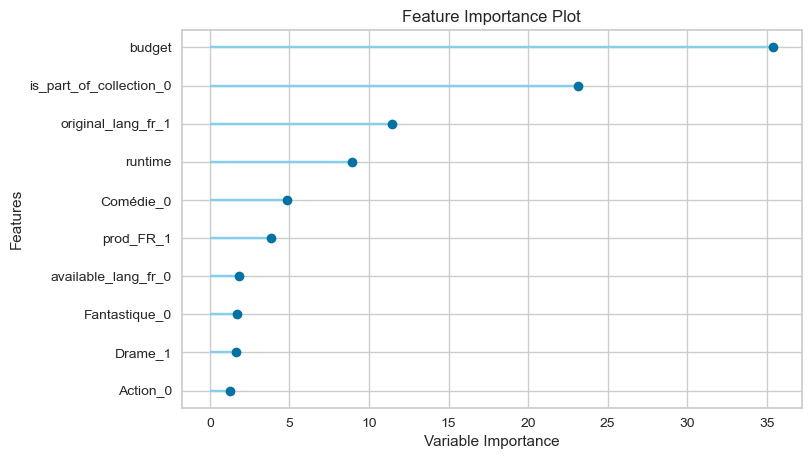

In [27]:
plot_model(tuned_lightgbm, plot = 'feature')

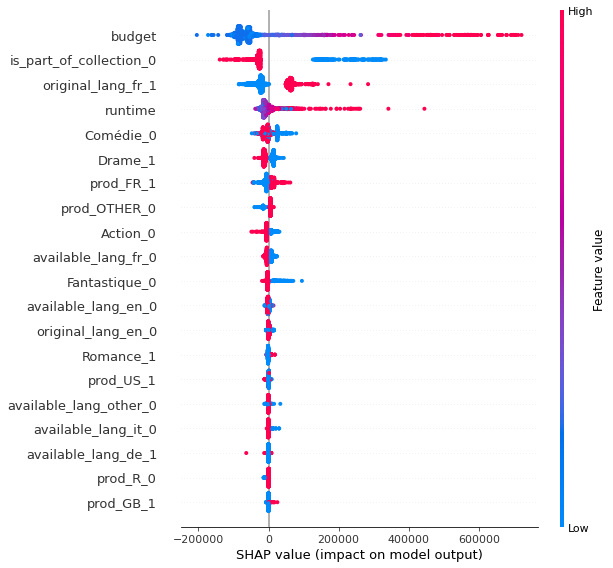

In [24]:
interpret_model(tuned_lightgbm)

### Prédiction

In [43]:
# TODO: faire un train-test split plus haut car là déjà fitté
data_to_predict = data.sample(10)
X = data.drop('sales', axis=1)
y = data.sales

X.head()

,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,original_lang_other,available_lang_de,...,prod_FR,prod_GB,prod_H,prod_O,prod_OTHER,prod_R,prod_S,prod_T,prod_U,prod_US
4507,0,25000000.0,120.0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2901,0,22000000.0,142.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2897,0,25000000.0,116.0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5915,0,25000000.0,77.0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
5439,0,26500000.0,135.0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [44]:
pred_holdouts = predict_model(tuned_lightgbm, data=X)
pred_holdouts.head()

,is_part_of_collection,budget,runtime,original_lang_en,original_lang_es,original_lang_fr,original_lang_it,original_lang_ja,original_lang_other,available_lang_de,...,prod_GB,prod_H,prod_O,prod_OTHER,prod_R,prod_S,prod_T,prod_U,prod_US,Label
4507,0,25000000.0,120.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,242516.558910
2901,0,22000000.0,142.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,118397.738418
2897,0,25000000.0,116.0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,75088.035908
5915,0,25000000.0,77.0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,48232.019742
5439,0,26500000.0,135.0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,158184.650348


In [54]:
pd.concat([pred_holdouts[['Label']], y], axis=1)

,Label,sales
4507,242516.558910,139087.0
2901,118397.738418,66228.0
2897,75088.035908,32954.0
5915,48232.019742,1463152.0
5439,158184.650348,82240.0
...,...,...
425,44106.200878,22292.0
426,71988.504286,25924.0
429,114715.913397,30218.0
441,121056.257851,11185.0


In [49]:
print(prettify_metrics(get_evaluation_metrics(y, pred_holdouts.Label)))

Evaluation:
----------
- MAPE: 1112.98
- MSE: 241855.66
- RMSE: 58494158622.74
- MAE: 132304.3
- R2: 0.51


# Modélisation d'une baseline avec Pycaret et le dataset non transformé

In [97]:
import pycaret.regression as pcr
import pandas as pd
from lib.preprocessing.load import read_movies_entrees, read_movies_features

In [19]:
# We first read the french movies "entrées"
bo = read_movies_entrees('../data/french-box-office-29nov2020.json')

# Then fetch their main features. Note that it seems not all movies were found in the feature database
features = read_movies_features('../data/movie-features-29nov2020.json')

# Let's merge both dataframes

data = pd.merge(bo, features, on='id')

In [20]:
data.head()

,year,title,id,sales,release_date,is_adult,is_part_of_collection,budget,genres,original_language,production_countries,languages,runtime
0,2019,Maléfique : Le Pouvoir du Mal,19073,786485,2019-10-16,False,True,185000000,"[Fantastique, Familial, Aventure]",en,[US],[en],110.0
1,2019,Nous finirons ensemble,18875,1261701,2019-05-01,False,True,0,"[Comédie, Drame]",fr,"[BE, FR]",[fr],135.0
2,2019,Spider-Man: Far from Home,18243,1370178,2019-07-03,False,True,160000000,"[Action, Aventure, Science-Fiction]",en,[US],"[cs, nl, en, de, it]",129.0
3,2019,Jumanji: next level,18258,785636,2019-12-04,False,True,125000000,"[Aventure, Comédie, Fantastique]",en,[US],[en],123.0
4,2019,Dragons 3 : Le monde caché,18167,1224811,2019-02-06,False,True,129000000,"[Animation, Familial, Aventure]",en,"[JP, US]",[en],104.0


In [111]:
data = data.dropna()
data = data.sort_values(by='release_date')
data = data.drop(['id', 'release_date', 'year'], axis=1)

In [122]:
reg = pcr.setup(data, target='sales')

,Description,Value
0,session_id,2474
1,Target,sales
2,Original Data,"(7006, 10)"
3,Missing Values,False
4,Numeric Features,2
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(4904, 5525)"


In [124]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,132419.7289,70542491408.5613,264686.5748,0.4123,2.3585,10.6611,19.4640
xgboost,Extreme Gradient Boosting,130763.4469,71306159718.4000,266068.2906,0.4062,2.3264,9.9377,71.1320
gbr,Gradient Boosting Regressor,137465.3728,72377910974.6236,268245.9316,0.3968,2.4245,12.2211,11.7080
lightgbm,Light Gradient Boosting Machine,140250.5040,75323296856.5856,273660.8303,0.3707,2.3427,10.7386,1.0680
llar,Lasso Least Angle Regression,139868.3129,78146734327.5570,279003.4419,0.3483,2.3756,11.7953,1.4860
rf,Random Forest Regressor,126965.7378,79225231506.0471,280789.0662,0.3390,2.1520,4.8878,61.0260
en,Elastic Net,146038.3094,79665575526.4000,281734.3312,0.3349,2.4232,12.4396,12.7220
lasso,Lasso Regression,135028.6109,82516382515.2000,286682.3750,0.3117,2.2839,7.6890,9.7440
br,Bayesian Ridge,154221.4461,84268978161.4984,289807.5354,0.2961,2.4899,14.6171,10732.9860
lr,Linear Regression,154222.9625,84290129100.8000,289849.4562,0.2960,2.4895,14.5769,25.5440


In [125]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,128220.9166,56370349714.5421,237424.4084,0.5750,1.9862,11.2960
1,132920.0040,57290811741.0383,239354.9911,0.3382,1.9020,10.7610
2,155529.8222,82548902952.7498,287313.2488,0.1119,2.2768,8.3250
3,135341.0714,93984779854.2327,306569.3720,0.3462,2.2420,8.7899
4,129446.8654,69419381256.4997,263475.5800,0.1800,2.5797,11.5595
5,144270.0472,81425138572.4283,285350.9043,0.4468,2.6433,11.2081
6,142684.3088,79678348124.7161,282273.5342,0.4071,2.2057,10.3242
7,147275.7193,83339496218.1489,288685.8088,0.4102,2.0797,6.9992
8,143401.5955,75146952257.5466,274129.4443,0.3865,2.6835,9.1301
9,128895.1488,67564240062.6464,259931.2218,0.3850,2.7076,14.6461


In [128]:
tuned_lightgbm = tune_model(lightgbm, n_iter=50, optimize = 'RMSE')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,127049.2629,55404805883.8990,235382.2548,0.5823,1.9946,10.8352
1,130670.7371,54691291461.9649,233861.6930,0.3683,1.9235,10.5381
2,151926.9197,72849165881.7694,269905.8463,0.2163,2.2499,8.2081
3,129743.6405,83856828681.6920,289580.4356,0.4167,2.2429,10.1438
4,130632.6009,63205947481.2278,251407.9304,0.2534,2.5936,14.4933
5,141372.9537,75877432014.9041,275458.5849,0.4844,2.6289,11.6024
6,144674.6892,79465706520.1215,281896.6238,0.4087,2.2153,10.1705
7,141005.7423,76083299751.1164,275832.0136,0.4616,2.0325,7.1360
8,139513.0806,68289514761.2711,261322.6258,0.4425,2.7030,10.8328
9,125208.4865,61032839683.7190,247048.2538,0.4445,2.7056,14.5701


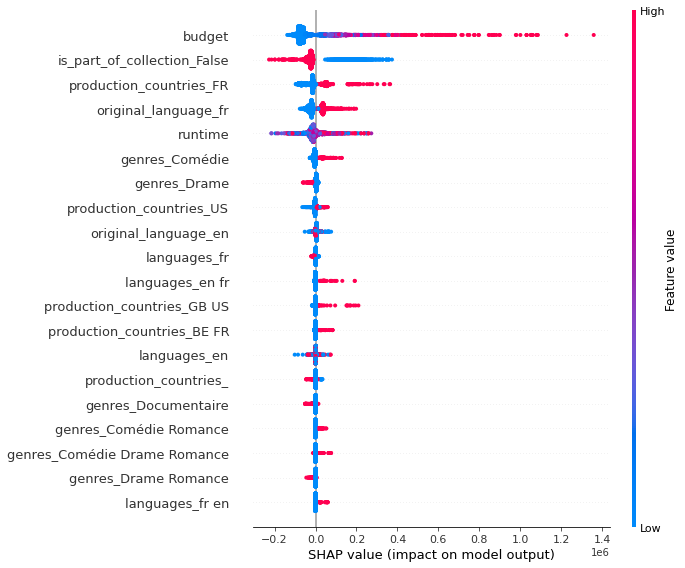

In [130]:
interpret_model(lightgbm)

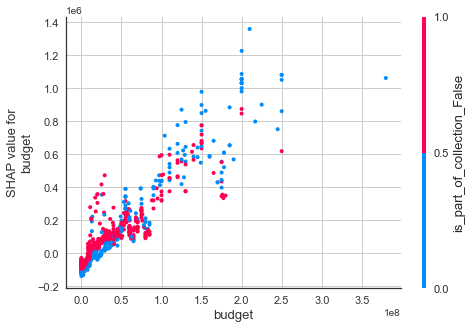

In [136]:
interpret_model(lightgbm, plot='correlation')

In [137]:
interpret_model(lightgbm, plot = 'reason', observation = 12)

In [138]:
save_model(lightgbm, model_name='light_gbm_best-model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='sales',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                  LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                  

In [142]:
get_config('X_train').shape

(4904, 5525)